## Importing necessary libraries

In [ ]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import PIL
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

## Setting up Constant Variables

In [ ]:
# setting variables
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 100 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224,224]
EPOCHS = 800

In [ ]:
# setting up kaggle api to download data set
'''
!pip install kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
'''

'\n!pip install kaggle\nfrom google.colab import files\nfiles.upload()\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n'

In [ ]:
# downloading Alzheimer's dataset from Kaggle environment 
#!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

In [ ]:
# unzipping downloaded dataset
#!unzip /content/alzheimers-dataset-4-class-of-images.zip

## Splitting dataset for Training and Validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
print(train_ds)

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


## Setting up the number of classes in dataset

In [ ]:
# Setting up classes
classes = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = classes
val_ds.class_names = classes

NUM_CLASSES = len(classes)
print(classes[0]+' \t\t-> '+" When it becomes clear to family and doctors that a person is having significant trouble with memory.\n")
print(classes[1]+' \t-> '+" People grow more confused and forgetful and begin to need more help with daily activities and self-care\n")
print(classes[2]+' \t\t-> '+" Memory loss of recent events, Difficulty with problem-solving, complex tasks and sound judgments, etc\n")
print(classes[3]+' \t-> '+" People with VeryMildDementia have minor changes in their memory and thinking ability. These changes aren't significant enough to affect work or relationships yet.\n")

MildDementia 		->  When it becomes clear to family and doctors that a person is having significant trouble with memory.

ModerateDementia 	->  People grow more confused and forgetful and begin to need more help with daily activities and self-care

NonDementia 		->  Memory loss of recent events, Difficulty with problem-solving, complex tasks and sound judgments, etc

VeryMildDementia 	->  People with VeryMildDementia have mild changes in their memory and thinking ability. These changes aren't significant enough to affect work or relationships yet.



## Visulaizing the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

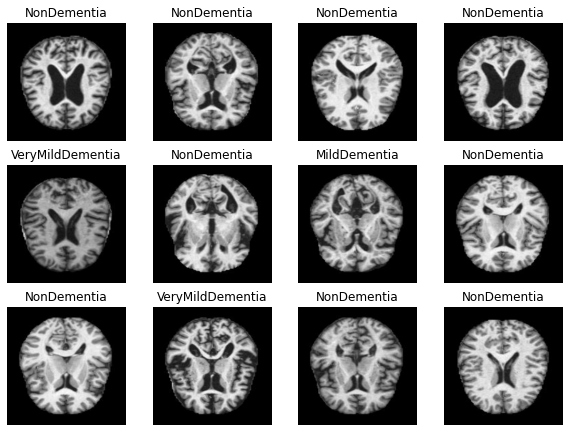

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

## Feature Engineering

Since we have categorical data in our model, we need to convert them to one-hot encoding.
One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering.

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes our data much more efficient

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Preprocessing and Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=None , save_prefix="", save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## ROC AUC Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [ ]:
NUM_IMAGES = []

for label in classes:
    dir_name = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
print(NUM_IMAGES)

[717, 52, 2560, 1792]


Since our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC.
Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

## Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using tf.keras, we can easily build up the layers of our CNN.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)
        
),
        
        conv_block(20),
        conv_block(50),
                                  
        
        #conv_block(96),
        #tf.keras.layers.Dropout(0.2),
                                  
        
        #conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        
       tf.keras.layers.Flatten(),
       # dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        
        keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
        
        tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

## Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The learning rate is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/800
41/41 [==============================] - 67s 1s/step - loss: 1.4381 - accuracy: 0.7393 - precision: 0.4655 - recall: 0.2808 - auc: 0.6775 - val_loss: 67.9640 - val_accuracy: 0.7476 - val_precision: 0.4951 - val_recall: 0.4951 - val_auc: 0.6634
Epoch 2/800
41/41 [==============================] - 52s 1s/step - loss: 0.9269 - accuracy: 0.7945 - precision: 0.6497 - recall: 0.3867 - auc: 0.8366 - val_loss: 11.3426 - val_accuracy: 0.7478 - val_precision: 0.4956 - val_recall: 0.4951 - val_auc: 0.6651
Epoch 3/800
41/41 [==============================] - 52s 1s/step - loss: 0.8568 - accuracy: 0.8144 - precision: 0.6998 - recall: 0.4508 - auc: 0.8620 - val_loss: 1.1780 - val_accuracy: 0.7644 - val_precision: 0.5345 - val_recall: 0.4463 - val_auc: 0.8140
Epoch 4/800
41/41 [==============================] - 52s 1s/step - loss: 0.8004 - accuracy: 0.8232 - precision: 0.7183 - recall: 0.4821 - auc: 0.8807 - val_loss: 2.7434 - val_accuracy: 0.6821 - val_precision: 0.3643 - val_recall: 0.3

41/41 [==============================] - 52s 1s/step - loss: 0.0441 - accuracy: 0.9956 - precision: 0.9921 - recall: 0.9901 - auc: 0.9999 - val_loss: 0.0894 - val_accuracy: 0.9841 - val_precision: 0.9696 - val_recall: 0.9668 - val_auc: 0.9984
Epoch 34/800
41/41 [==============================] - 52s 1s/step - loss: 0.0432 - accuracy: 0.9955 - precision: 0.9913 - recall: 0.9909 - auc: 0.9999 - val_loss: 0.0892 - val_accuracy: 0.9849 - val_precision: 0.9716 - val_recall: 0.9678 - val_auc: 0.9984
Epoch 35/800
41/41 [==============================] - 52s 1s/step - loss: 0.0412 - accuracy: 0.9963 - precision: 0.9934 - recall: 0.9919 - auc: 0.9999 - val_loss: 0.0895 - val_accuracy: 0.9851 - val_precision: 0.9716 - val_recall: 0.9688 - val_auc: 0.9979
Epoch 36/800
41/41 [==============================] - 52s 1s/step - loss: 0.0442 - accuracy: 0.9964 - precision: 0.9931 - recall: 0.9925 - auc: 0.9999 - val_loss: 0.0893 - val_accuracy: 0.9851 - val_precision: 0.9716 - val_recall: 0.9688 - val_a

## Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

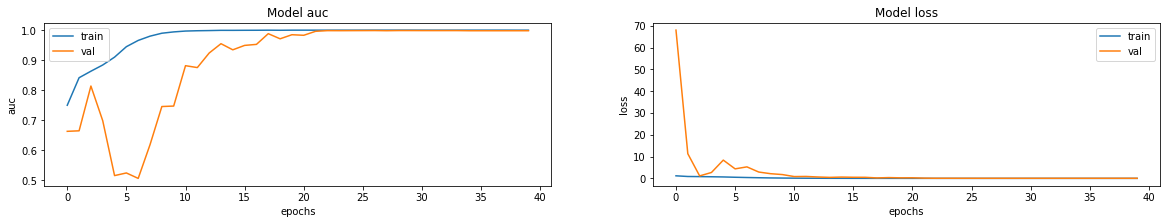

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

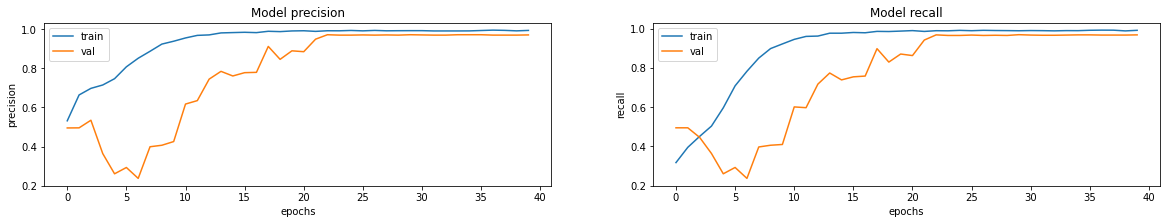

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
_ = model.evaluate(test_ds)

13/13 [==============================] - 12s 422ms/step - loss: 23.9724 - accuracy: 0.8329 - precision: 0.6691 - recall: 0.6560 - auc: 0.8693


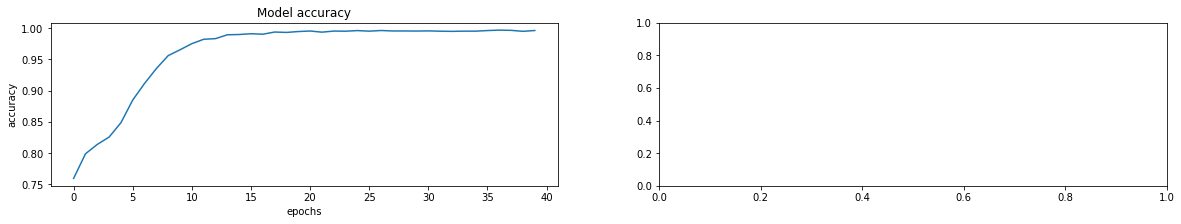

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy']):
    ax[i].plot(history.history[met])
   # ax[i].plot(history.history[ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    #ax[i].legend(['train', 'test'])

In [ ]:
model.save_weights('first_try.h5')

In [1]:
# zip all output files
# !tar -zcvf outputname.tar.gz /kaggle/working

In [ ]:
# Generating downloadable output file
from IPython.display import FileLink
#FileLink(r'./outputname.tar.gz')